In [ ]:
#parsing through lines of the text file
#to turn it into a df where rows represent the lines
import pandas as pd
dataset=pd.read_csv("amazon-meta.txt",delimiter="\t",on_bad_lines='skip')
dataset.to_csv('amazon_1.csv')

In [ ]:
#read the parsed file
dataset.to_csv('amazon_1.csv')

# Schema 1: Product Information

In [ ]:
#separate identifier and value into separate columns
import re 
import numpy as np
df['name'] = np.nan
df['value'] = np.nan
df['out'] = np.nan
#prod = pd.DataFrame(columns = columns)
def schema1(row):
    if (row.startswith('Id: ')):
        return ('Id: ', int(re.findall(r'\d+',row)[0]))
    elif (row.startswith('ASIN: ')):
        return ('ASIN: ', row[6:])
    elif (row.find('title:')!=-1):
        return  ('title:', row[row.find('title:')+ 6:])
    elif (row.find('group:')!=-1):
        return ('group:', row[row.find('group:')+ 6:])
    elif (row.find('salesrank:')!=-1):
        return  ('salesrank:', row[row.find('salesrank:')+10:])
    else:
        return (np.nan, np.nan)
df['out'] =  df['# Full information about Amazon Share the Love products'].apply(lambda row: schema1(row))

df['name'], df['value'] = zip(*df['out'])

need = df[['name','value']]

need = need.dropna()

need.to_csv("nonan_need_parsed_2cols.csv")

In [ ]:
need = pd.read_csv("nonan_need_parsed_2cols.csv")

#%%
columns = ['pid','asin','title','group','salesrank']
df = pd.DataFrame(index=range(548553),columns = columns)
#if consequtive rows are ids, then move to next row
#because the first one is discontinued 
i = 0
p = 0
while (i<len(need)):
    if need['name'].iloc[i] == 'Id: ':
        p= p+1
        df['pid'].iloc[p] = need['value'].iloc[i]
    elif need['name'].iloc[i] == 'ASIN: ':
        df['asin'].iloc[p] = need['value'].iloc[i]
    elif need['name'].iloc[i] == 'title:':
        df['title'].iloc[p] = need['value'].iloc[i]
    elif need['name'].iloc[i] == 'group:':
        df['group'].iloc[p] = need['value'].iloc[i]
    elif need['name'].iloc[i] == 'salesrank:':
        df['salesrank'].iloc[p] = need['value'].iloc[i]
    i = i+1
    
df = df.drop(0)
df.reset_index(drop=True)
df.to_csv('schema1.csv')

# Schema 2: Similarity Information

In [ ]:
import pandas as pd 
df = pd.read_csv('amazon_1.csv',index_col=0)

import re 
import numpy as np
df['name'] = np.nan
df['value'] = np.nan
df['out'] = np.nan

def schema2(row):
    if (row.startswith('Id: ')):
        return ('Id: ', int(re.findall(r'\d+',row)[0]))
    elif (row.startswith('  similar:')):
        return ('similar: ', row[11:])
    else:
        return (np.nan, np.nan)
df['out'] =  df['# Full information about Amazon Share the Love products'].apply(lambda row: schema2(row))

df['name'], df['value'] = zip(*df['out'])

df = df.dropna()

df = df[['name','value']]

df = df.reset_index(drop=True)
temp = df['value'].str.split(' ', expand=True)

temp = temp.drop(temp.columns[[1,3,5,7,9]],axis = 1)
temp.columns = ['sim_n','sim1','sim2','sim3','sim4','sim5']
schema2 = pd.concat([df, temp], axis=1)

schema2.to_csv('schema2temp.csv')

df = pd.read_csv('schema2temp.csv',index_col = 0)

i = 0
while(i<1091232):
    if (df.iloc[i]['name'] == 'Id: ') & (df.iloc[i+1]['name'] == 'similar: '):
        df.loc[i,['sim_n','sim1','sim2','sim3','sim4','sim5']] = df.loc[i+1,['sim_n','sim1','sim2','sim3','sim4','sim5']]
    i= i+1
    
df = df[df.name != 'similar: ']
df.rename(columns={'value':'Id'}, inplace=True)

df = df.drop(df.columns[0],axis = 1)
df= df.drop(0)
df.reset_index(drop=True)

df.to_csv('schema2.csv')

# Schema 4: Customer Review Information 

In [ ]:
import pandas as pd
df = pd.read_csv('amazon_1.csv',index_col=0)

import re 
import numpy as np
df['name'] = np.nan
df['value'] = np.nan
df['out'] = np.nan
#prod = pd.DataFrame(columns = columns)
def schema4(row):
    if (row.startswith('Id: ')):
        return ('Id: ', int(re.findall(r'\d+',row)[0]))
    elif (row.startswith('  reviews: total:')):
        return ('reviews: ', row[row.find("  reviews: total: ")+18:(row.find("downloaded:")-2)])
    elif (row.find('cutomer:')!=-1):
        return ('customer: ', row[row.find("cutomer: ")+9:(row.find("rating:")-2)])
    else:
        return (np.nan, np.nan)
df['out'] =  df['# Full information about Amazon Share the Love products'].apply(lambda row: schema4(row))

df['name'], df['value'] = zip(*df['out'])

df = df.dropna()
df = df[['name','value']]

df.to_csv("schema4temp.csv")

# Matching Similarity Information

In [ ]:
#matching similarity values id-asin1-asin2-asin3-asin4-asin4-asin5
import pandas as pd 
#similarity table 
sim = pd.read_csv("schema2.csv",index_col = 0)
#co-purchasing table 
copurchase = pd.read_csv("copurchase.csv",index_col = 0)
#general id table
general= pd.read_csv("schema1.csv",index_col = 0)

general = general.loc[general['group'] == " Book"]
general = general.loc[general['salesrank'] <= 150000]
general = general.loc[general['salesrank'] > -1]

general.columns = ["Id","asin","title","group","salesrank"]

similarity = pd.merge(general,sim, on ="Id", how = "left")

similarity = similarity[["Id","sim1","sim2","sim3","sim4","sim5"]]

genshort = general[["Id","asin"]]

genshort.columns = ["pid","asin"]

sim1 = similarity[["Id","sim1"]]
sim1.columns = ["Id","asin"]
tempy1 = pd.merge(sim1, genshort, on='asin', how = "left")

sim2= similarity[["Id","sim2"]]
sim2.columns = ["Id","asin"]
tempy2 = pd.merge(sim2, genshort, on='asin',how = "left")

sim3= similarity[["Id","sim3"]]
sim3.columns = ["Id","asin"]
tempy3 = pd.merge(sim3, genshort, on='asin',how = "left")

sim4= similarity[["Id","sim4"]]
sim4.columns = ["Id","asin"]
tempy4 = pd.merge(sim4, genshort, on='asin',how = "left")

sim5= similarity[["Id","sim5"]]
sim5.columns = ["Id","asin"]
tempy5 = pd.merge(sim5, genshort, on='asin',how = "left")

tempy1 = tempy1[["Id","pid"]]
tempy1.columns = ["Id","sim1"]
tempy2 = tempy2[["Id","pid"]]
tempy2.columns = ["Id","sim2"]
tempy3 = tempy3[["Id","pid"]]
tempy3.columns = ["Id","sim3"]
tempy4 = tempy4[["Id","pid"]]
tempy4.columns = ["Id","sim4"]
tempy5 = tempy5[["Id","pid"]]
tempy5.columns = ["Id","sim5"]

final = pd.merge(tempy1, tempy2, on='Id',how = "left")

final = pd.merge(final, tempy3, on='Id')
final = pd.merge(final, tempy4, on='Id')
final = pd.merge(final, tempy5, on='Id')

final_sorted = final.sort_values("Id")

final_melted = final_sorted.melt(id_vars =['Id'], value_vars = ['sim1','sim2','sim3','sim4','sim5'],
                  var_name = 'sim', value_name = 'sim_product')

final_melted = final_melted.sort_values("Id")

final_melted1 = final_melted.dropna(subset=['sim_product'], how='all')

final_melted = final_melted1[["Id","sim_product"]]

final_melted.reset_index(drop= True)

final_melted.to_csv("similarity_id.csv",index = False)



# Graph Network Analysis

In [2]:
# importing necessary packages
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import pylab
import community
from matplotlib.pyplot import subplots
%matplotlib inline

In [3]:
# products dataframe represents the parsed data about the sold Amazon products
products = pd.read_csv("schema1_cleaned.csv", index_col=False)
# taking the subset of products with a designated group
products.dropna(subset=['group'], inplace=True)
# books dataframe represents a subset of products under the group Book
books = products.loc[products['group'].str.contains("Book")]
# we limited our scope at first to books with a salesrank above 150000 -- this was later further limited due to the size of the data
books = books[(books['salesrank'] <= 150000) & (books['salesrank'] > -1)]
# converting types for consistency
books['pid'] = books['pid'].astype(int)
books['asin'] = books['asin'].astype(str)
# titles of the books are converted into a dictionary (used for the graph node labels)
pid_titles = pd.Series(books.title.values,index=books.pid).to_dict()

# df_sim dataframe represents each book id with the id of another book it is often co-purchased with or considered similar to
df_sim = pd.DataFrame(pd.read_csv('similarity_id.csv'))

In [4]:
# filtering the books down to those with above a 5000 salesrank
df_filter=books[(books['salesrank']<=5000)]
# filtering df_sim to match the above query
df_sim_filt=df_sim[df_sim.Id.isin(df_filter.pid) & df_sim.sim_product.isin(df_filter.pid)]
# calculating the in-degree (number of appearances of the ID as a similar product of other products)
in_degree_filt=df_sim_filt.groupby(['Id'])['sim_product'].size().reset_index(name='in_degree')
# calculating the out-degree (number of similar products of a certain ID)
out_degree_filt=df_sim_filt.groupby(['sim_product'])['Id'].size().reset_index(name='out_degree')

#resetting indexes and column names
x_filt = out_degree_filt.set_index('sim_product').rename_axis('Source')
y_filt = in_degree_filt.set_index('Id').rename_axis('Source')
y_filt.columns = x_filt.columns
# combining in-degree and out-degree for total degree table
combined_filt=y_filt.add(x_filt, fill_value=0).loc[y_filt.index, :].reset_index()
clean_combined = combined_filt
clean_combined.rename(columns = {'out_degree': "total_degree"}, inplace=True)
# finding the largest total degrees
print(clean_combined.nlargest(5, 'total_degree'))

# sim_freq counts the frequency of each node combination (used in graph network for weighting)
sim_freq=df_sim_filt.groupby(['Id','sim_product']).size().reset_index(name='Freq')
sim_freq['Id'] = sim_freq['Id'].astype(int)
sim_freq['sim_product'] = sim_freq['sim_product'].astype(int)
sim_freq

        Source  total_degree
697   199628.0          32.0
344    98756.0          29.0
1705  502086.0          24.0
625   180888.0          23.0
1708  502784.0          23.0


,Id,sim_product,Freq
0,296,376858,1
1,296,424705,1
2,296,532042,1
3,448,75848,1
4,448,104366,1
...,...,...,...
4378,543274,69183,1
4379,543274,108697,1
4380,548529,92880,1
4381,548529,176485,1


In [5]:
# showing the IDs and their similar products in a cleaner table
sim_cleaned = df_sim_filt.reset_index()
sim_cleaned.iloc[:, 1:]

,Id,sim_product
0,296.0,424705.0
1,296.0,532042.0
2,296.0,376858.0
3,448.0,75848.0
4,448.0,475036.0
...,...,...
4378,543274.0,69183.0
4379,543274.0,108697.0
4380,548529.0,92880.0
4381,548529.0,176485.0


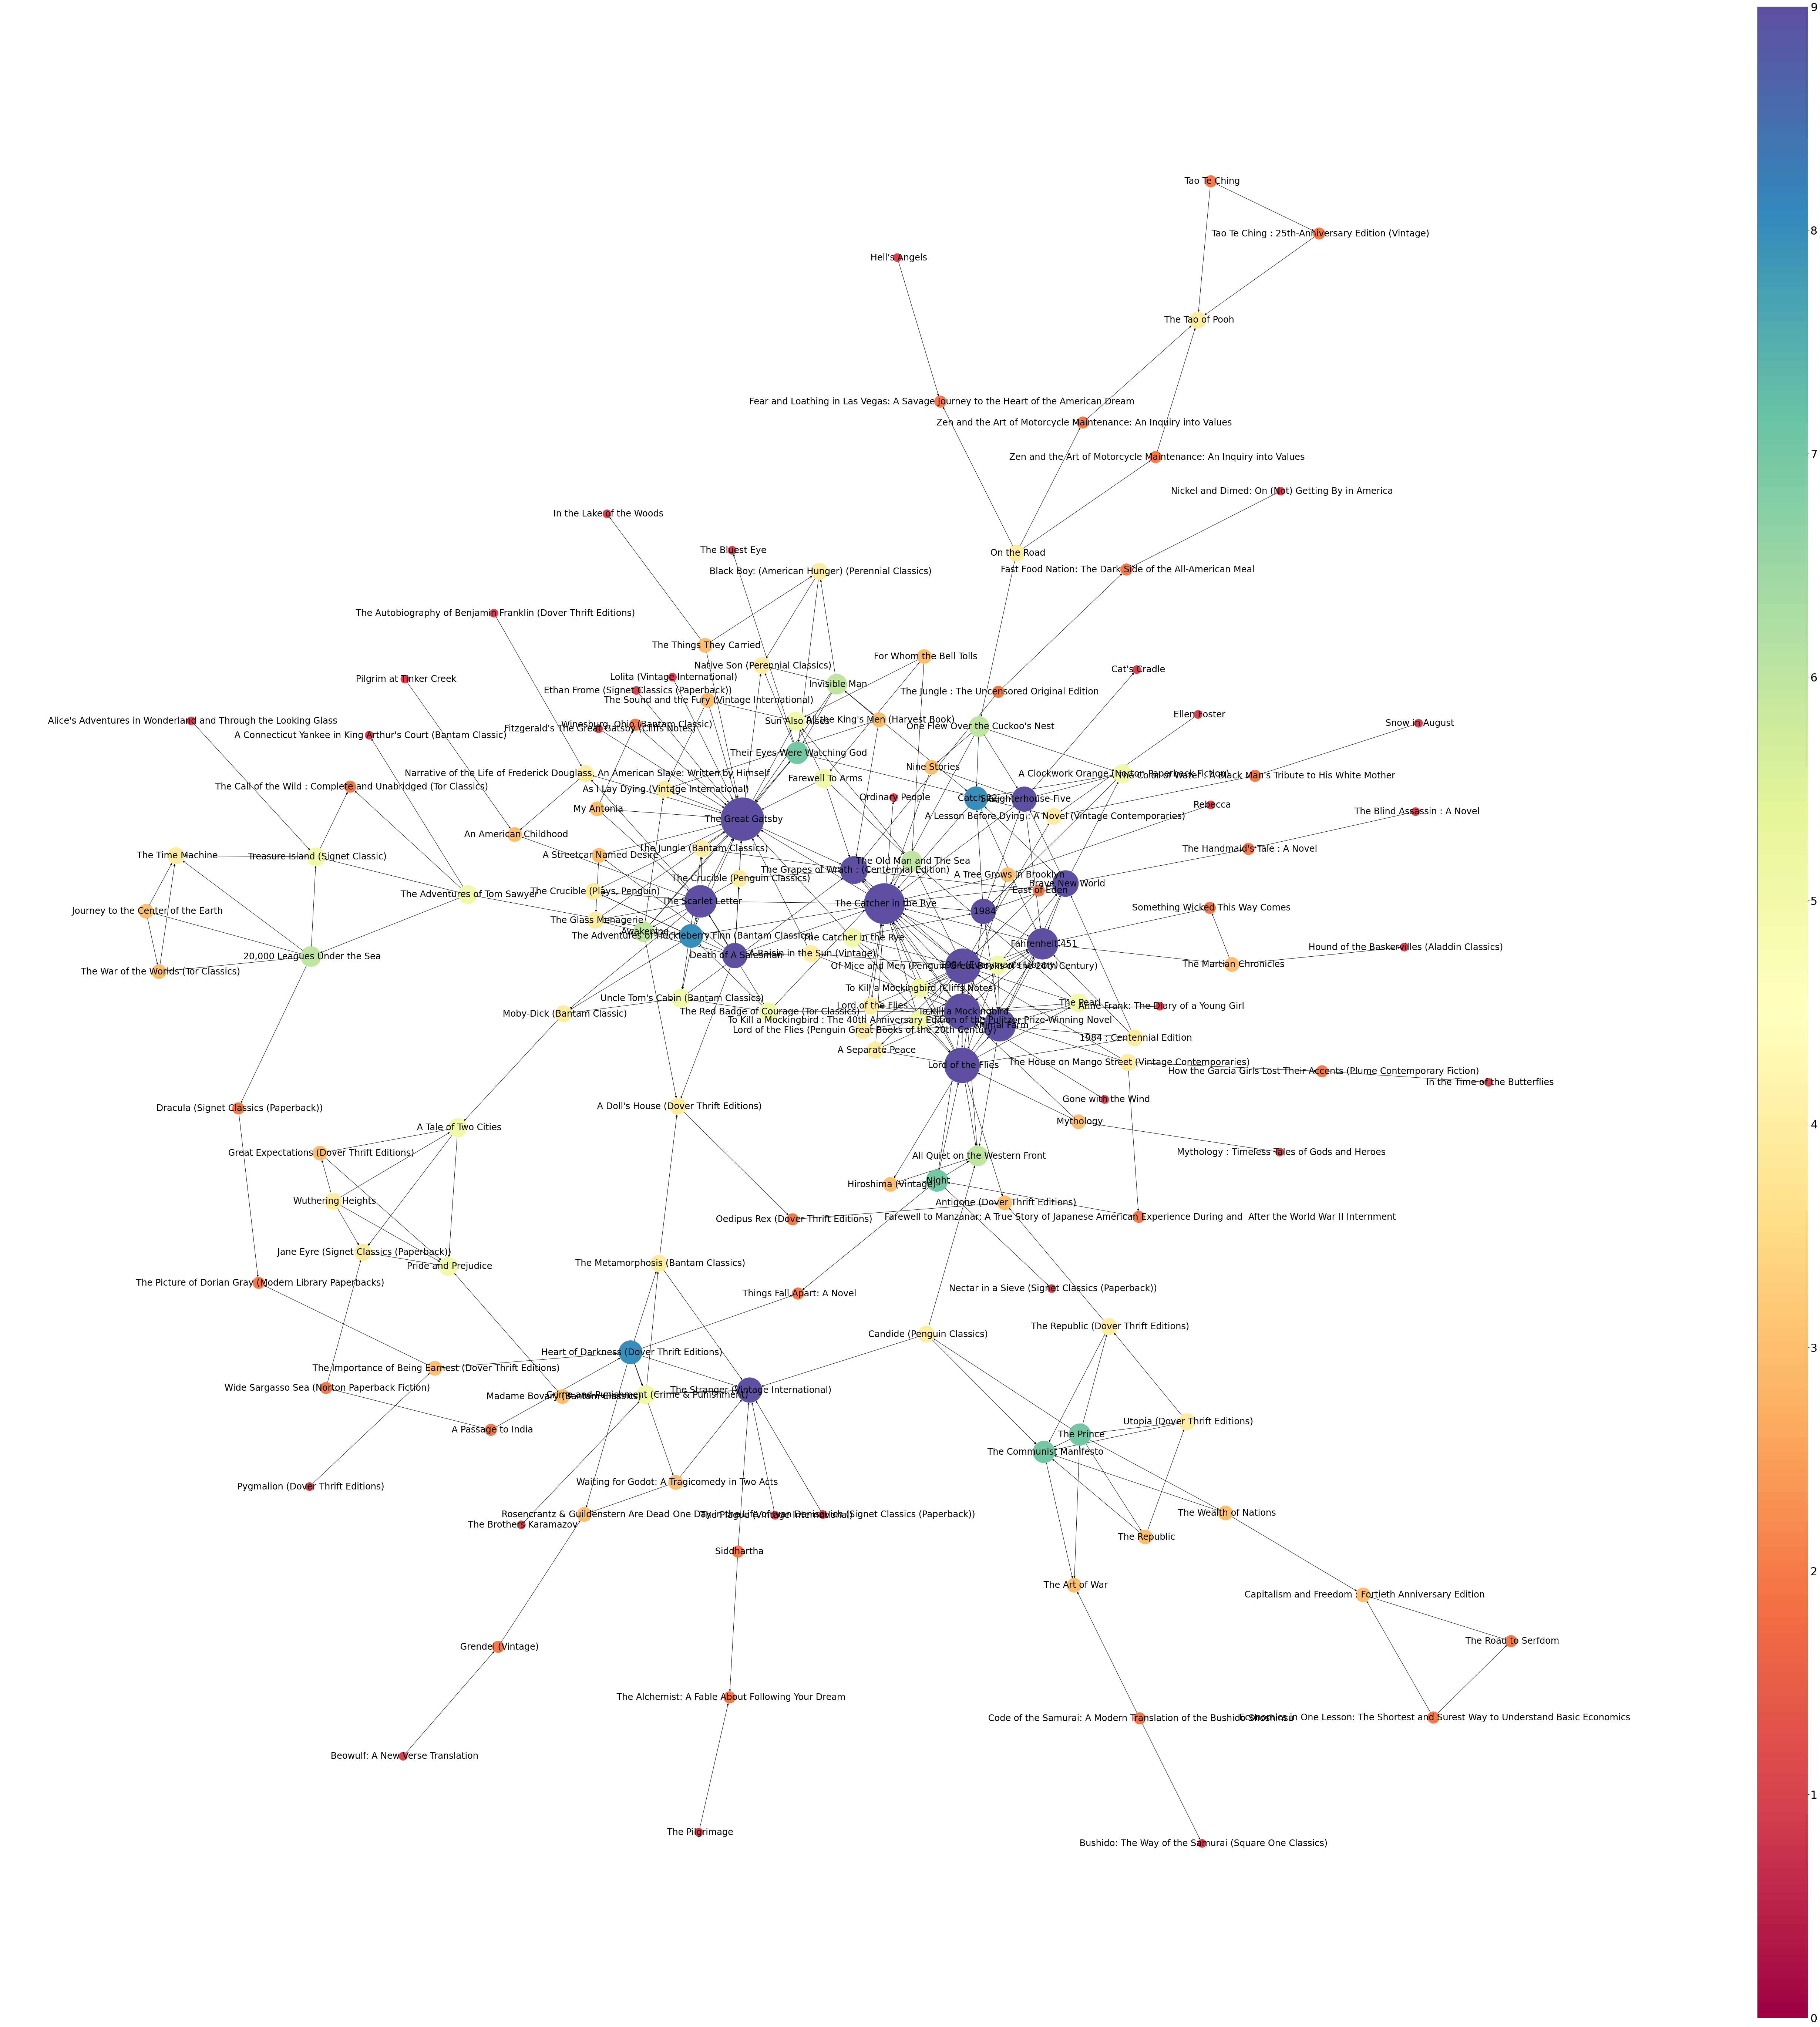

<Figure size 7200x4800 with 0 Axes>

In [6]:
# creating the graph using IDs and similar products as connected nodes weighted by frequency of the same pair occurring
g = nx.from_pandas_edgelist(sim_freq, 'Id', 'sim_product', ['Freq'])

fig, ax = subplots()
# focusing on node 577 as the subgraph
subnet = nx.node_connected_component(g,577)
pos=nx.kamada_kawai_layout(g.subgraph(subnet))

# setting colormap
cmapC = plt.cm.get_cmap('Spectral')
# degrees as a dictionary of Node ID and Degree
degrees = dict(g.subgraph(subnet).degree())
# keys is used as the nodelist in drawing the graph
keys = degrees.keys()
keys = list(keys)

nodes = dict(g.subgraph(subnet).nodes())
n_color = np.asarray([degrees[n] for n in nodes])
edges = dict(g.subgraph(subnet).edges())
weights = [g.subgraph(subnet)[u][v]['Freq'] for u,v in edges]
colors=range(10)
vmin = min(colors)
vmax = max(colors)

# labels for the nodes based on the product title
node_titles = {}
for i in nodes.keys():
    node_titles[i] = pid_titles.get(i)

# creating the actual graph with the titles as labels for each node and sized based on degree
draw=nx.draw_kamada_kawai(g.subgraph(subnet), with_labels = True,nodelist=keys, 
               node_size=[v*500 for v in degrees.values()]
                ,cmap=cmapC,width=weights,arrows=True,node_color=n_color,vmin=vmin, vmax=vmax, labels=node_titles, font_size=24)

plt.xticks([], [])
plt.yticks([], [])
fig = plt.gcf()
fig.set_size_inches(100, 100)
sm = plt.cm.ScalarMappable(cmap=cmapC, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar=plt.colorbar(sm,aspect=40)
cbar.ax.tick_params(labelsize=30)

plt.figure(dpi=1200)
plt.savefig("network448_sr5000.png")
plt.show()

# Degree and Salesrank Analysis

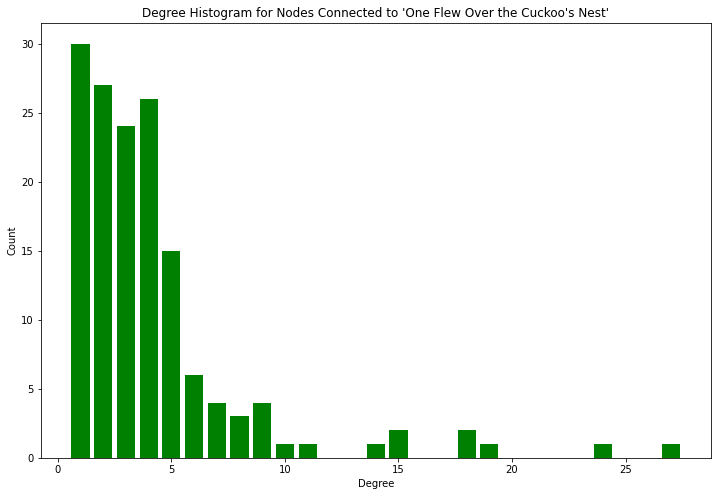

In [10]:
import collections
import seaborn as sns
degree_sequence = sorted([d for n, d in g.subgraph(subnet).degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.8, color='g')
plt.title("Degree Histogram for Nodes Connected to 'One Flew Over the Cuckoo's Nest'")
plt.ylabel("Count")
plt.xlabel("Degree")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.savefig("degree577hist.png")
plt.show()

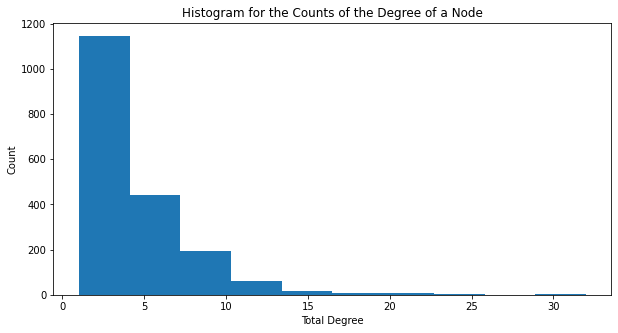

In [8]:
sr5000_ranks = books[books.pid.isin(combined_filt.Source)]
sr5000_comb = sr5000_ranks.merge(combined_filt, left_on='pid', right_on='Source', how='right')
sr5000_comb_sort = sr5000_comb.sort_values("salesrank")

# Displaying a histogram of the number of nodes with different degrees
fig, axis = plt.subplots(figsize =(10, 5))
axis.hist(sr5000_comb_sort['total_degree'])
plt.xlabel('Total Degree')
plt.ylabel('Count')
plt.title("Histogram for the Counts of the Degree of a Node")
plt.show()

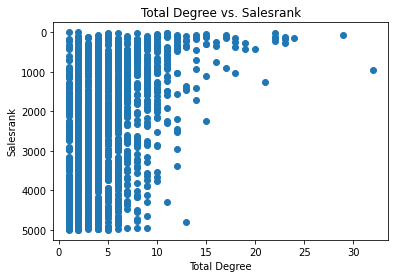

In [13]:
# Scatterplot of the Total degree versus the node's salesrank
plt.scatter(sr5000_comb_sort['total_degree'], sr5000_comb_sort['salesrank'])
plt.title('Total Degree vs. Salesrank')
plt.xlabel('Total Degree')
plt.ylabel('Salesrank')
plt.gca().invert_yaxis()
plt.show()